<a href="https://colab.research.google.com/github/crispitagorico/Neural-SPDEs/blob/main/examples/example_Ginzburg_Landau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1> Stochastic Ginzburg-Landau Equation</h1> </center>

*The Stochastic Ginzburg-Landau equation is also known as the Allen-Cahn equation in 1-dimension and is used for modeling various physical phenomena like superconductivity.*

*In this notebook we demonstrate that the Neural SPDE model is capable of learning dynamics described by the Stochastic Ginzburg-Landau equation,*
\begin{align*}
    \partial_t u - \Delta u &= 3u -u^3 + \xi,  \\
    u(t,0) &= u(t,1),  \nonumber\\
    u(0,x) &= u_0(x), \quad (t,x)\in [0,T]\times[0,1] \nonumber
\end{align*}
*with better accuracy and using only a modest amount of training data compared to all alternative models.*
***

In [ ]:
# clone the github repository if using Google Colab

In [ ]:
%cd Neural-SPDEs/

In [ ]:
!pip install -r requirements.txt

In [4]:
import torch
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from timeit import default_timer

In [9]:
import warnings
import torch.optim as optim
from utilities import *
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The two cells below are for the format of the figures. 

In [ ]:
# # To avoid type 3 figures. This may take a long time
# !sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
# !pip install latex
# !sudo apt install cm-super

In [ ]:
# # Using seaborn's style
# plt.style.use('seaborn-colorblind')
# width = 345
# tex_fonts = {
#     "text.usetex": True,
#     "font.family": "serif",
#     "axes.labelsize": 24,
#     "font.size": 24,
#     "legend.fontsize": 24,
#     "xtick.labelsize": 24,
#     "ytick.labelsize": 24,
# }
# plt.rcParams.update(tex_fonts)

**Load a dataset**

In [6]:
data = scipy.io.loadmat('../drive/MyDrive/data_phi41+/Phi41+_u0_xi_{}.mat'.format(1200))

In [ ]:
# data = scipy.io.loadmat('../drive/MyDrive/data_phi41+/Phi41+_xi_{}.mat'.format(1200))

The data has been saved in the following format

* $O_X[j]=x_j$, 
* $O_T[k]=t_k$
* $W[i,j,k]=\xi^i(x_j,t_k), \qquad i=1,\ldots,N_\text{train}+N_\text{test}$
* $Sol[i,j,k]=u^i(x_j,t_k), \qquad i=1,\ldots,N_\text{train}+N_\text{test}$



In [7]:
O_X, O_T, W, Sol = data['X'], data['T'], data['W'], data['sol']

In [8]:
xi = torch.from_numpy(W.astype(np.float32))
data = torch.from_numpy(Sol.astype(np.float32))

# 1) Neural SPDE demo
***

In [10]:
from torchspde.neural_spde import *

**Get the dataloaders**

Specifying `dataset='phi41'` overrides $T$ and $sub_t$

In [11]:
train_loader, test_loader = dataloader_nspde_1d(u=data, xi=xi, ntrain=1000, 
                                                ntest=200, T=51, sub_t=1, 
                                                batch_size=20, dim_x=128, 
                                                dataset='phi41')

**Define an NSPDE model**

In [ ]:
model = NeuralSPDE(dim=1, in_channels=1, noise_channels=1, hidden_channels=16, 
                   n_iter=4, modes1=32, modes2=32).cuda()

In [ ]:
print('The model has {} parameters'. format(count_params(model)))

The model has 265089 parameters


**Train the NSPDE model**

In [ ]:
loss = LpLoss(size_average=False)

In [ ]:
model, losses_train, losses_test = train_nspde_1d(model, train_loader, test_loader, 
                                                  device, loss, batch_size=20, epochs=5000, 
                                                  learning_rate=0.025, scheduler_step=100, 
                                                  scheduler_gamma=0.5, print_every=5)

Epoch 0000 | Total Train Loss 0.293192 | Total Test Loss 0.115780
Epoch 0005 | Total Train Loss 0.077225 | Total Test Loss 0.051700
Epoch 0010 | Total Train Loss 0.061719 | Total Test Loss 0.060662
Epoch 0015 | Total Train Loss 0.053639 | Total Test Loss 0.055151
Epoch 0020 | Total Train Loss 0.055901 | Total Test Loss 0.057288
Epoch 0025 | Total Train Loss 0.050813 | Total Test Loss 0.041213
Epoch 0030 | Total Train Loss 0.047613 | Total Test Loss 0.037498
Epoch 0035 | Total Train Loss 0.048238 | Total Test Loss 0.042166
Epoch 0040 | Total Train Loss 0.049441 | Total Test Loss 0.037886
Epoch 0045 | Total Train Loss 0.039971 | Total Test Loss 0.034018
Epoch 0050 | Total Train Loss 0.045484 | Total Test Loss 0.034856
Epoch 0055 | Total Train Loss 0.037293 | Total Test Loss 0.041168
Epoch 0060 | Total Train Loss 0.053926 | Total Test Loss 0.057077
Epoch 0065 | Total Train Loss 0.034342 | Total Test Loss 0.032346
Epoch 0070 | Total Train Loss 0.037811 | Total Test Loss 0.045189
Epoch 0075

In [ ]:
# torch.save(model.state_dict(), '../drive/MyDrive/data_phi41+/nspde_u0_xi_1200.pth')

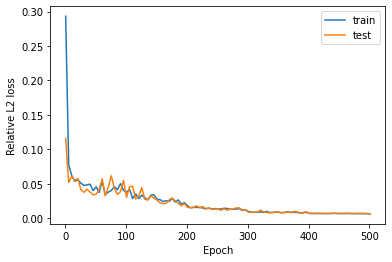

In [ ]:
plt.plot(np.arange(1,len(losses_train)*5, 5), losses_train, label='train')
plt.plot(np.arange(1,len(losses_test)*5, 5), losses_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Relative L2 loss')
plt.legend()
plt.show()

**Visualize predictions**

In [ ]:
from utilities import plot_1d, contour_plot_1d

In [ ]:
plot_1d(model, test_loader, device, i=1, T_=5, T=51, a=1)

In [ ]:
contour_plot_1d(model, test_loader, device, O_X[0,:-1], O_T[0,:51])

**Memory profiling** 

In [ ]:
mem_log = []
for u0_, xi_, u_ in train_loader:
    input = u0_.to(device), xi_.to(device)
    break
try:
    mem_log.extend(log_mem(model, input, exp='baseline'))
except Exception as e:
    print(f'log_mem failed because of {e}')
    
df = pd.DataFrame(mem_log)
plot_mem(df, exps=['baseline'])

**Super-resolution demonstration**

We start by loading a dataset with a finer spatial resolution

In [ ]:
batch_size = 20
ntest = 200

data = scipy.io.loadmat('../drive/MyDrive/data_phi41+/Phi41+_super_xi_u0_{}.mat'.format(ntest))
O_X, O_T, W, Sol = data['X'], data['T'], data['W'], data['sol']
xi = torch.from_numpy(W.astype(np.float32))
data = torch.from_numpy(Sol.astype(np.float32))

_, test_loader = dataloader_nspde_1d(u=data, xi=xi, ntrain=100, ntest=200, batch_size=batch_size, 
                                     dim_x=512, dataset='phi41')

Then we load a model which has been trained on a lower resolution

In [ ]:
model = NeuralSPDE(dim=1, in_channels=1, noise_channels=1, hidden_channels=16, 
                   n_iter=4, modes1=32, modes2=32).cuda()
model.load_state_dict(torch.load('../drive/MyDrive/data_phi41+/nspde_u0_xi_1200_500epochs.pth'))

<All keys matched successfully>

Finally we evaluate the model on the finer resolution dataset

In [ ]:
myloss = LpLoss(size_average=False)
test_loss = 0.
with torch.no_grad():
    for u0_, xi_, u_ in test_loader:    
        loss = 0.       
        u0_, xi_, u_ = u0_.to(device), xi_.to(device), u_.to(device)
        u_pred = model(u0_, xi_)
        loss = myloss(u_pred[...,1:].reshape(batch_size, -1), u_[...,1:].reshape(batch_size, -1))
        test_loss += loss.item()
print('Super-resolution test Loss {:.6f} with {} spatial points'.format(test_loss / ntest, 
                                                                        xi_.shape[-2]))

Super-resolution test Loss 0.005817 with 512 spatial points


# 2) Baselines
***

### FNO (space-time FFT)

In [ ]:
from baselines.FNO1D import FNO_space1D_time, dataloader_fno_1d_xi, dataloader_fno_1d_u0, train_fno_1d

**Get the dataloaders**

There are two different dataloaders. One is when we want to learn the map $u_0|_{O_X}\mapsto u|_{O_X\times O_T}$. The other one is when we want to learn the map $\xi|_{O_X\times O_T}\mapsto u|_{O_X\times O_T}$

In [ ]:
train_loader, test_loader = dataloader_fno_1d_xi(u=data, xi=xi, ntrain=1000, 
                                                 ntest=200, T=51, sub_t=1, batch_size=20, 
                                                 dim_x=128, dataset='phi41')

In [ ]:
# train_loader, test_loader = dataloader_fno_1d_u0(u=data, ntrain=1000, 
#                                                  ntest=200, T=51, sub_t=1, batch_size=20, 
#                                                  dim_x=128, dataset='phi41')

**Define an FNO model**

One needs to specify the number of observations in time for the input. When the input is the forcing $T>1$ (e.g. here $T=51$) and when the input is the initial condition $T=1$

In [ ]:
model = FNO_space1D_time(modes1=32, modes2=24, width=32, T=1, L=4).cuda()

In [ ]:
print('The model has {} parameters'. format(count_params(model)))

**Train the FNO model**

In [ ]:
loss = LpLoss(size_average=False)

In [ ]:
model, losses_train, losses_test = train_fno_1d(model, train_loader, test_loader, 
                                                device, loss, batch_size=20, epochs=5000, 
                                                learning_rate=0.001, scheduler_step=100, 
                                                scheduler_gamma=0.5, print_every=5)

**Memory profiling**

In [ ]:
mem_log = []
for xi_, u_ in train_loader:
    input = xi_.to(device)
    break
try:
    mem_log.extend(log_mem(model, input, exp='baseline', model_type='FNO'))
except Exception as e:
    print(f'log_mem failed because of {e}')
    
df = pd.DataFrame(mem_log)
plot_mem(df, exps=['baseline'])

###NCDE

In [ ]:
from baselines.NCDE import NeuralCDE, dataloader_ncde_1d, train_ncde_1d

**Get the dataloaders**

In [ ]:
dim_x = 128
train_loader, test_loader, normalizer = dataloader_ncde_1d(u=data, xi=xi, ntrain=1000, 
                                                           ntest=200, T=51, sub_t=1, 
                                                           batch_size=20, dim_x=dim_x, 
                                                           normalizer=True, interpolation='linear',
                                                           dataset='phi41')

**Define an NCDE model**


In [ ]:
model = NeuralCDE(input_channels=dim_x+1, hidden_channels=16, output_channels=dim_x, 
                  interpolation='linear').cuda()

In [ ]:
print('The model has {} parameters'. format(count_params(model)))

**Train the NCDE model**

In [ ]:
loss = LpLoss(size_average=False)

In [ ]:
model, losses_train, losses_test = train_ncde_1d(model, train_loader, test_loader, normalizer,
                                                device, loss, batch_size=20, epochs=5000, 
                                                learning_rate=0.001, scheduler_step=100, 
                                                scheduler_gamma=0.5, print_every=1)

In [ ]:
mem_log = []
for u0_, xi_, u_ in train_loader:
    input = u0_.to(device), xi_.to(device)
    break
try:
    mem_log.extend(log_mem(model, input, exp='baseline'))
except Exception as e:
    print(f'log_mem failed because of {e}')

df = pd.DataFrame(mem_log)
plot_mem(df, exps=['baseline'])

#NRDE

In [ ]:
from baselines.NRDE import NeuralRDE, dataloader_nrde_1d, train_nrde_1d

In [ ]:
import signatory

In [ ]:
print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

**Get the dataloaders**

In [ ]:
dim_x = 128
train_load, test_load, I, noise_size, norm = dataloader_nrde_1d(u=data, xi=xi, ntrain=1000, 
                                                                ntest=200, T=51, sub_t=1, 
                                                                batch_size=20, dim_x=dim_x, 
                                                                depth=2, window_length=10, 
                                                                normalizer=True, 
                                                                interpolation='linear',
                                                                dataset='phi41')

**Define an NRDE model**


In [ ]:
model = NeuralRDE(control_channels=noise_size, input_channels=dim_x, 
                  hidden_channels=2, output_channels=dim_x, interval=I, 
                  interpolation='linear').cuda()

In [ ]:
print('The model has {} parameters'. format(count_params(model)))

**Train the NRDE model**

In [ ]:
loss = LpLoss(size_average=False)

In [ ]:
model, losses_train, losses_test = train_nrde_1d(model, train_load, test_load, norm,
                                                device, loss, batch_size=20, epochs=5000, 
                                                learning_rate=0.001, scheduler_step=100, 
                                                scheduler_gamma=0.5, print_every=1)

### NCDE-FNO

In [ ]:
from baselines.NCDEFNO_1D import NeuralCDE, dataloader_ncdeinf_1d, train_ncdeinf_1d

**Get the dataloaders**

In [ ]:
train_loader, test_loader = dataloader_ncdeinf_1d(data, xi, ntrain=1000, ntest=200, T=51, 
                                                  sub_t=1, batch_size=20, dim_x=128, 
                                                  interpolation='linear', dataset=None)

**Define an NCDE-FNO model**


In [ ]:
model = NeuralCDE(data_size=1, noise_size=1, hidden_channels=32, output_channels=1, 
                  interpolation='linear').cuda()

In [ ]:
print('The model has {} parameters'. format(count_params(model)))

**Train the NCDE-FNO model**

In [ ]:
loss = LpLoss(size_average=False)

In [ ]:
model, losses_train, losses_test = train_ncdeinf_1d(model, train_loader, test_loader, 
                                                    device, loss, batch_size=20, epochs=5000, 
                                                    learning_rate=0.001, scheduler_step=100, 
                                                    scheduler_gamma=0.5, print_every=1)

**Memory profiling**

In [ ]:
mem_log = []
for u0_, xi_, u_ in train_loader:
    input = u0_.to(device), xi_.to(device)
    break
try:
    mem_log.extend(log_mem(model, input, exp='baseline'))
except Exception as e:
    print(f'log_mem failed because of {e}')

df = pd.DataFrame(mem_log)
plot_mem(df, exps=['baseline'])

### DeepONet

In [ ]:
from baselines.deepOnet import DeepONetCP, dataloader_deeponet_1d_u0, train_deepOnet_1d

**Get the dataloaders**

In [ ]:
train_loader, test_loader, grid = dataloader_deeponet_1d_xi(data, xi, ntrain=1000, ntest=200, 
                                                            T=51, sub_t=1, batch_size=20, 
                                                            dim_x=128, normalizer=False, 
                                                            dataset=None)

In [ ]:
train_loader, test_loader, grid = dataloader_deeponet_1d_u0(data, ntrain=1000, ntest=200, 
                                                            T=51, sub_t=1, batch_size=20, 
                                                            dim_x=128, normalizer=False, 
                                                            dataset=None)

**Define an deepOnet model**


In [ ]:
model = DeepONetCP(branch_layer=[128] + [300, 200],
                    trunk_layer=[2] + [100, 200, 200]).to(device)

In [ ]:
print('The model has {} parameters'. format(count_params(model)))

**Train the deepOnet model**

In [ ]:
loss = LpLoss(size_average=False)

In [ ]:
model, losses_train, losses_test = train_deepOnet_1d(model, train_loader, test_loader, grid,
                                                    normalizer, device, loss, batch_size=20, 
                                                    epochs=500, learning_rate=0.001, 
                                                    scheduler_step=100, scheduler_gamma=0.5, 
                                                    print_every=1)